#### This notebook contains scripts for calculation of product metrics (without any  analytical findings). Dataset was downloaded from https://www.kaggle.com/vijayuv/onlineretail

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

C:\Users\Nikita\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('OnlineRetail.csv', parse_dates=['InvoiceDate'])
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


### Monthly Revenue 

Text(0.5, 1.0, 'Monthly Revenu')

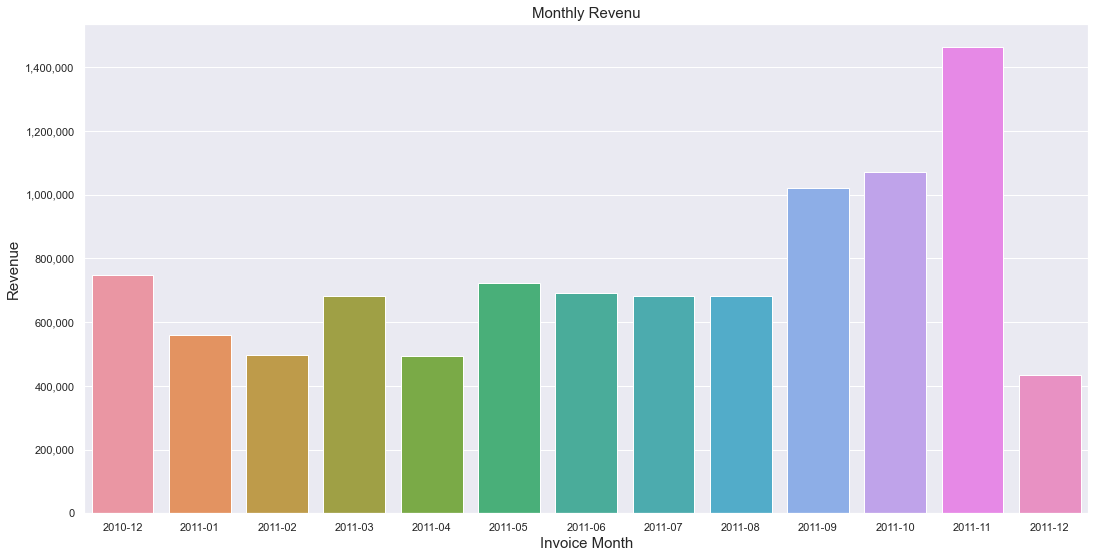

In [3]:
df['Revenue'] = df['Quantity'] * df['UnitPrice']
revenue_data = df.groupby(df['InvoiceDate'].dt.strftime('%Y-%m')).sum()[['Revenue']]

sns.set(rc={'figure.figsize':(18,9)})
sns.barplot(data = revenue_data, x=revenue_data.index, y='Revenue')

current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

plt.xlabel('Invoice Month', size=15)
plt.ylabel('Revenue', size=15)
plt.title('Monthly Revenu', size=15)

### Monthly Order Count

Text(0.5, 1.0, 'Monthly Order Count')

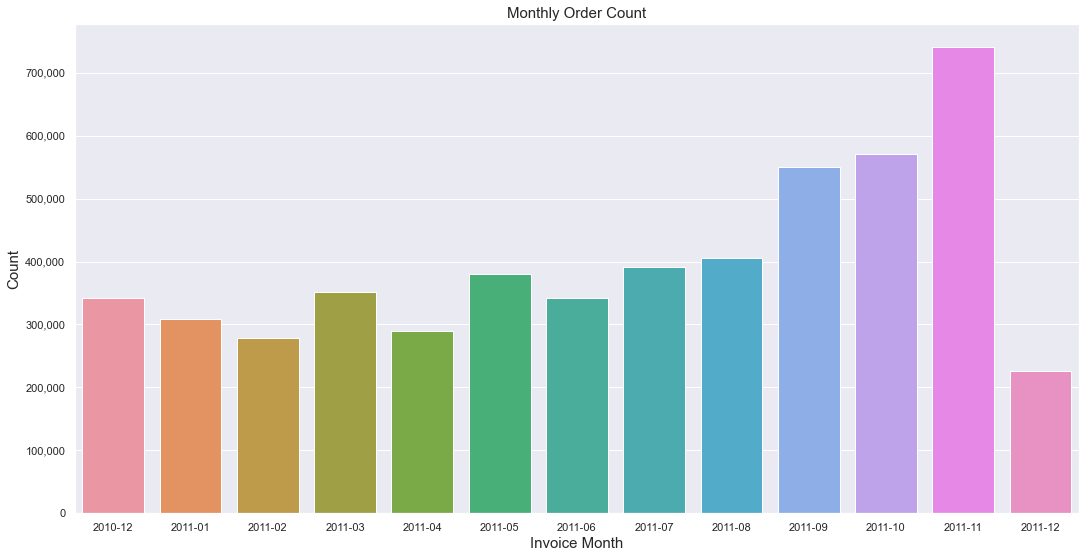

In [4]:
order_count_data = df.groupby(df['InvoiceDate'].dt.strftime('%Y-%m')).sum()[['Quantity']]

sns.barplot(data = order_count_data, x=order_count_data.index, y='Quantity')

current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

plt.xlabel('Invoice Month', size=15)
plt.ylabel('Count', size=15)
plt.title('Monthly Order Count', size=15)

### Average Revenue per Order

Text(0.5, 1.0, 'Average Revenue per Order')

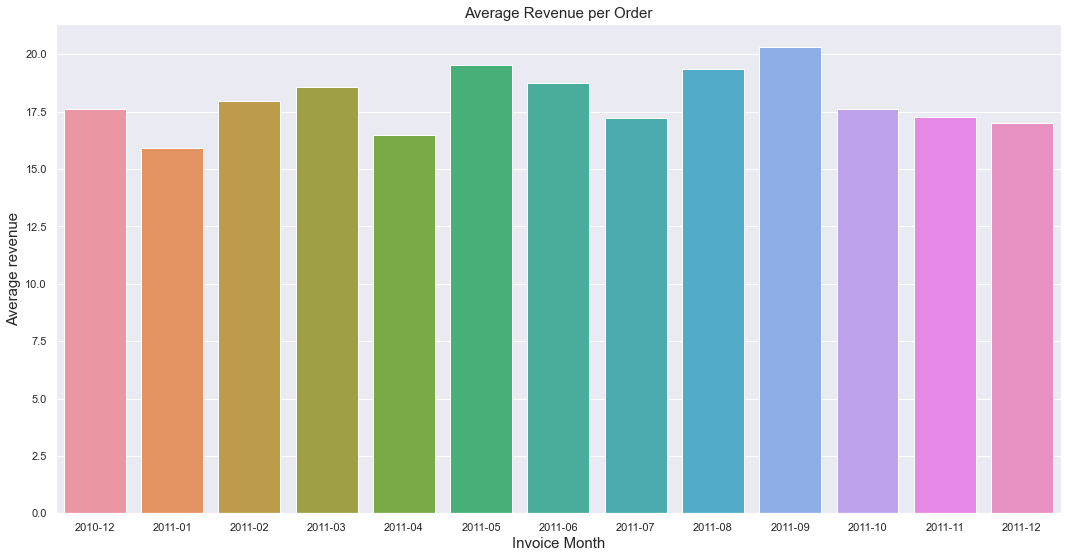

In [5]:
average_revenue_data = df.groupby(df['InvoiceDate'].dt.strftime('%Y-%m')).mean()[['Revenue']]

sns.barplot(data = average_revenue_data, x=average_revenue_data.index, y='Revenue')

plt.xlabel('Invoice Month', size=15)
plt.ylabel('Average revenue', size=15)
plt.title('Average Revenue per Order', size=15)

### Monthly Active Users

In [6]:
# Further analysis will be basis on UK users

df['Country'].value_counts()

United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon 

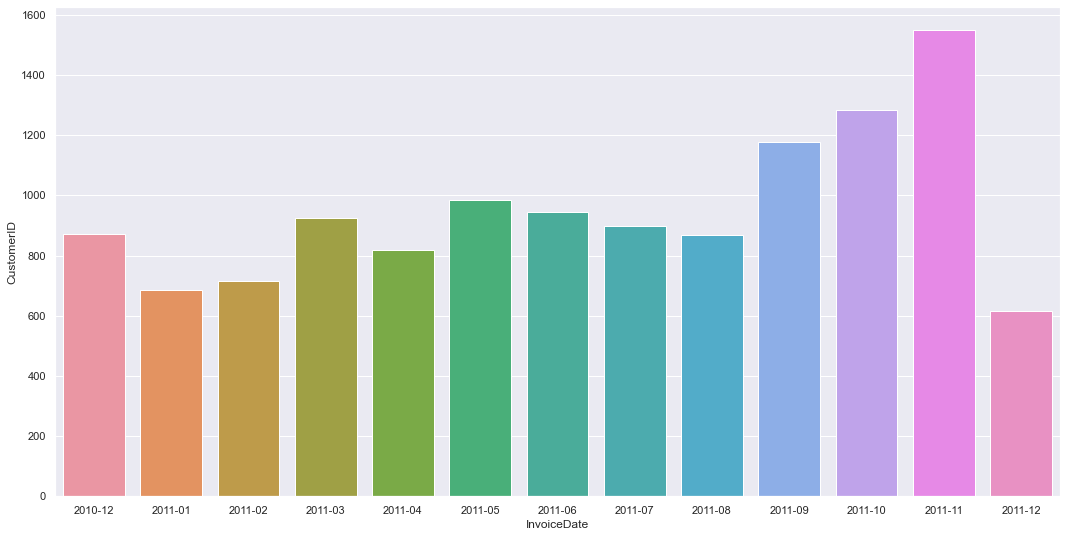

In [7]:
df_uk = df[df['Country'] == 'United Kingdom']
df_uk_monthly_users = df_uk.groupby(df['InvoiceDate'].dt.strftime('%Y-%m')).nunique()[['CustomerID']]

sns.barplot(data = df_uk_monthly_users, x=df_uk_monthly_users.index, y='CustomerID')

### Monthly Retention Rate

Text(0.5, 1.0, 'Monthly Retention Rate')

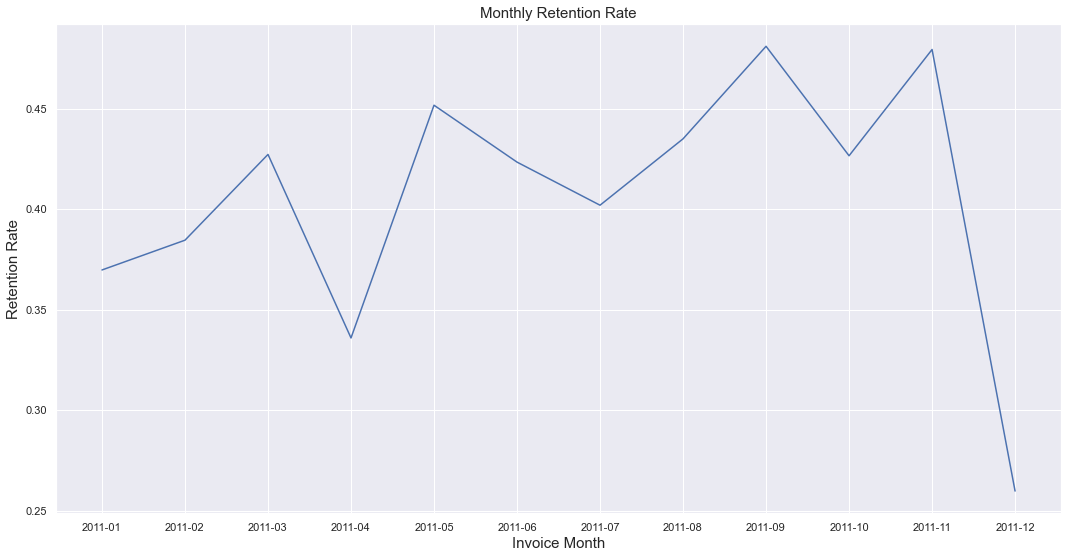

In [8]:
# Payments from users in terms of months
df_uk_users_pay = df_uk.groupby(['CustomerID', df['InvoiceDate'].dt.strftime('%Y-%m')]).sum()[['Revenue']].reset_index()

# Flag, were there any payments of users by all existing months in dataset 
df_uk_retention = pd.crosstab(df_uk_users_pay['CustomerID'], df_uk_users_pay['InvoiceDate']).reset_index()

# Calculation of RR for every month
months = df_uk_retention.columns[1:]
retention_array = []

for i in range(len(months)-1):
    retention_data = {}
    selected_month = months[i+1]
    prev_month = months[i]
    retention_data['InvoiceYearMonth'] = selected_month
    retention_data['TotalUserCount'] = df_uk_retention[prev_month].sum()
    retention_data['RetainedUserCount'] = df_uk_retention[(df_uk_retention[selected_month]>0) & (df_uk_retention[prev_month]>0)][selected_month].sum()
    retention_array.append(retention_data)
    
    
# Transformation of list to dataframe
df_uk_retention = pd.DataFrame(retention_array)
df_uk_retention['RetentionRate'] = df_uk_retention['RetainedUserCount'] / df_uk_retention['TotalUserCount']

# Visualization
sns.lineplot(data=df_uk_retention, x='InvoiceYearMonth', y='RetentionRate')
plt.xlabel('Invoice Month', size=15)
plt.ylabel('Retention Rate', size=15)
plt.title('Monthly Retention Rate', size=15)

### Cohort Based Retention Rate

In [9]:
# Calculation of first payment month for every user
df_uk_fp = df_uk.groupby('CustomerID').min()[['InvoiceDate']].reset_index().rename(columns={'InvoiceDate': 'MinPurchaseDate'})
df_uk_fp['MinPurchaseYearMonth'] = df_uk_fp['MinPurchaseDate'].dt.strftime('%Y-%m')


In [10]:
# Flag, were there any payments of users by all existing months in dataset + first payment month
df_uk_retention = pd.crosstab(df_uk_users_pay['CustomerID'], df_uk_users_pay['InvoiceDate']).reset_index()
df_uk_retention = pd.merge(df_uk_retention, df_uk_fp[['CustomerID','MinPurchaseYearMonth']],on='CustomerID')

In [11]:
# Calculation of RR for every cohort

retention_array = []
for i in range(len(months)):
    retention_data = {}
    selected_month = months[i]
    prev_months = months[:i]
    next_months = months[i+1:]
    for prev_month in prev_months:
        retention_data[prev_month] = np.nan
        
    total_user_count = df_uk_retention[df_uk_retention.MinPurchaseYearMonth ==  selected_month].MinPurchaseYearMonth.count()
    retention_data['TotalUserCount'] = total_user_count
    retention_data[selected_month] = 1 
    
    for next_month in next_months:
        retention_data[next_month] = np.round(df_uk_retention[(df_uk_retention['MinPurchaseYearMonth'] == selected_month) & (df_uk_retention[next_month]>0)][next_month].sum()/total_user_count,2)
    retention_array.append(retention_data)
    
    
df_uk_retention = pd.DataFrame(retention_array)
df_uk_retention.index = months

df_uk_retention

,TotalUserCount,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12
InvoiceDate,,,,,,,,,,,,,,
2010-12,871,1.0,0.37,0.33,0.38,0.35,0.40,0.38,0.35,0.35,0.40,0.37,0.49,0.27
2011-01,362,NaN,1.00,0.23,0.28,0.25,0.34,0.29,0.26,0.26,0.31,0.35,0.36,0.15
2011-02,339,NaN,NaN,1.00,0.25,0.19,0.28,0.28,0.25,0.26,0.28,0.28,0.31,0.10
2011-03,408,NaN,NaN,NaN,1.00,0.19,0.26,0.22,0.23,0.17,0.26,0.24,0.29,0.09
2011-04,276,NaN,NaN,NaN,NaN,1.00,0.22,0.22,0.22,0.21,0.23,0.23,0.26,0.08
2011-05,252,NaN,NaN,NaN,NaN,NaN,1.00,0.23,0.17,0.17,0.21,0.24,0.27,0.10
2011-06,207,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.21,0.16,0.25,0.26,0.32,0.10
2011-07,172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.20,0.19,0.23,0.28,0.11
2011-08,140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.26,0.23,0.26,0.14


### Prediction Model for LTV

Regression model will be built as follows:
1. Calculating of active user days: purchase date minus first payment date for every purchase.
2. Calculation of cumulative revenue for every users in terms of active days.
3. Building of regression model about dependence between  cumulative revenue and active days.

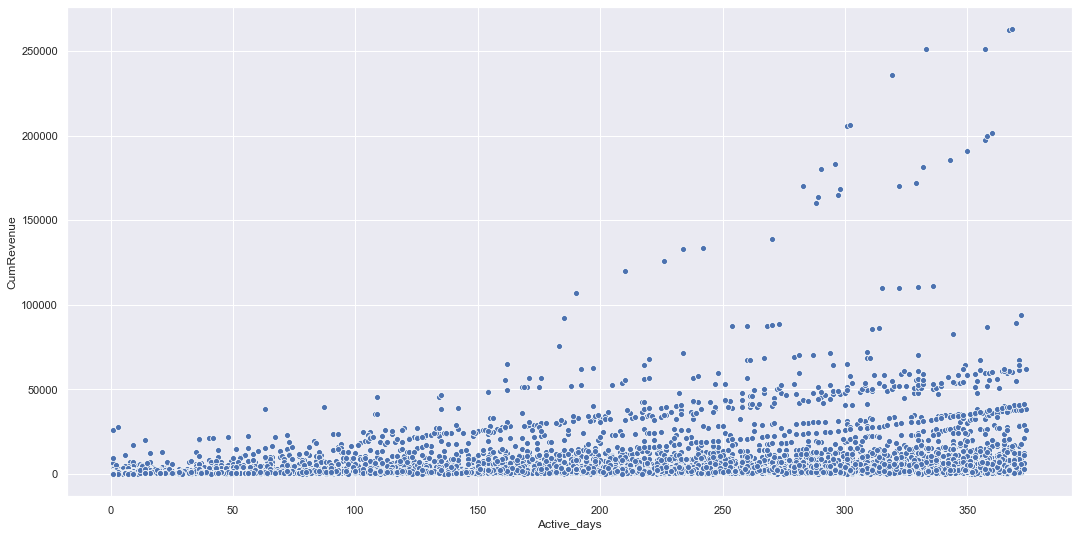

In [12]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date

# there were negative values of revenue 
df['Revenue'] = df['Revenue'].apply(lambda x: abs(x))
df_uk_fp['MinPurchaseDate'] = pd.to_datetime(df_uk_fp['MinPurchaseDate']).dt.date

# df contains first payment date and revenue of users in terms of invouce data
df_ltv = pd.merge(df.groupby(['CustomerID', 'InvoiceDate']).sum()[['Revenue']].reset_index(),
                  df_uk_fp[['CustomerID', 'MinPurchaseDate']], on='CustomerID')

# calculation will be basis on cohort 2010-12
df_ltv = df_ltv[df_ltv['MinPurchaseDate'] < pd.to_datetime(datetime.fromisoformat('2010-12-31'))]
df_ltv['Active_days'] = (df_ltv['InvoiceDate'] - df_ltv['MinPurchaseDate'] + timedelta(days=1)).dt.days


# Calculation of cumulative revenue
df_ltv['CumRevenue'] = df_ltv[['CustomerID', 'Revenue']].groupby('CustomerID').cumsum()


# df for the model
df_ltv_pred = df_ltv[['Active_days', 'CumRevenue']]
df_ltv_pred


sns.scatterplot(data=df_ltv_pred, x='Active_days', y='CumRevenue')

In [13]:
# splitting data
x = df_ltv_pred[['Active_days']]
y = df_ltv_pred[['CumRevenue']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

#### Linear Regression
Dependence between cumulative revenue and active days will be base as follow: y = w1 * x1 + b, 
where y is revenue, and x1 is active days

R-Square: 0.07343273687098606
MSE:  250986994.46216267


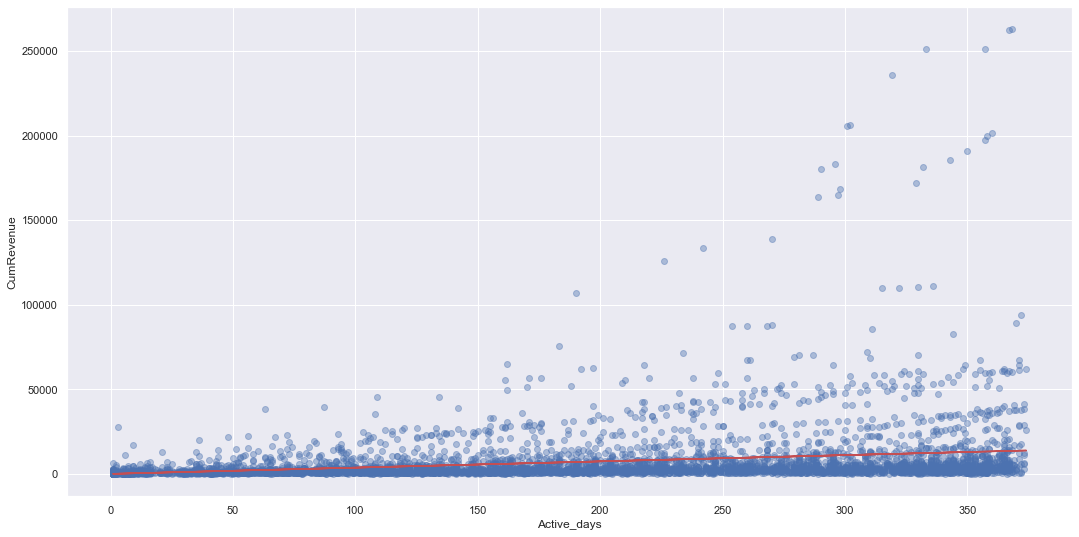

In [14]:
linr = LinearRegression()
linr.fit(x_train, y_train)

y_pred_linr = linr.predict(x_train)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Active_days')
ax1.set_ylabel('CumRevenue')
ax1.scatter(x_train, y_train, alpha = 0.4)
ax1.plot(x_train, y_pred_linr, 'r')

print('R-Square:',metrics.r2_score(y_train, y_pred_linr))
print('MSE: ',metrics.mean_squared_error(y_train, y_pred_linr))

Model has bad values of metrics, it is unfit for predictions.

#### Nonlinear Regression
Dependence between cumulative revenue and active days will be base as follow: y = w1 * ln(x) + b, 
where y is revenue, and x1 is active days

R-Square: 0.046041919466717096
MSE:  258406573.3850607


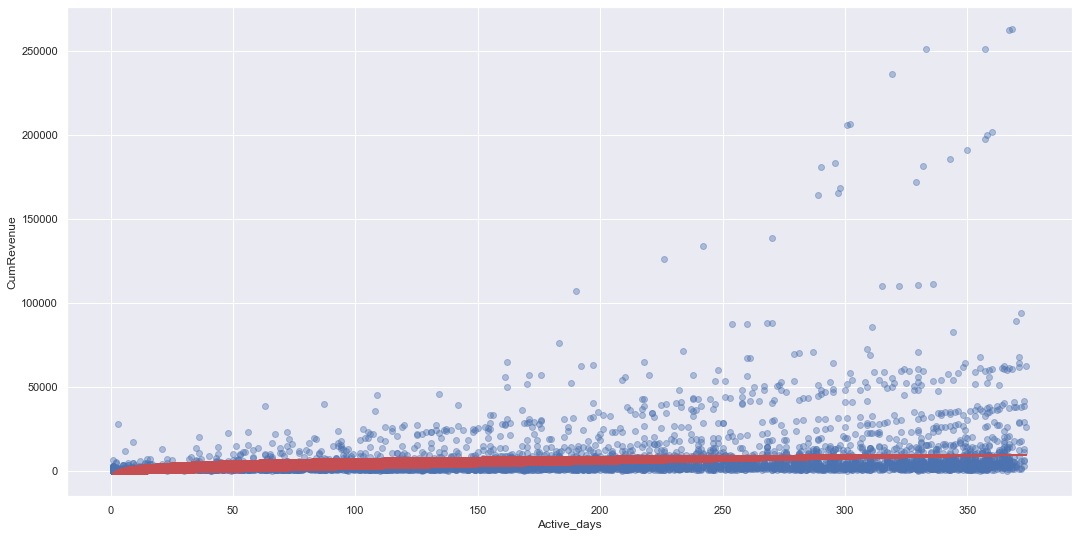

In [15]:
non_linr = LinearRegression()

x_train_nl = x_train.copy()
x_test_nl = x_test.copy()

x_train_nl['Active_days'] = x_train_nl['Active_days'].apply(lambda x: np.log(x))

non_linr.fit(x_train_nl, y_train)
y_pred_non_linr = non_linr.predict(x_train_nl)


fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Active_days')
ax1.set_ylabel('CumRevenue')
ax1.scatter(x_train, y_train, alpha = 0.4)
ax1.plot(x_train, y_pred_non_linr, 'r')

print('R-Square:',metrics.r2_score(y_train, y_pred_non_linr))
print('MSE: ',metrics.mean_squared_error(y_train, y_pred_non_linr))

Model has bad values of metrics, it is unfit for predictions.

#### Logarithms of target variable and regressor
Dependence between cumulative revenue and active days will be base as follow: ln(y) = w1 * ln(x) + b, where y is revenue, and x1 is active days

R-Square: 0.39318875365080164
MSE:  1.3935112701836019


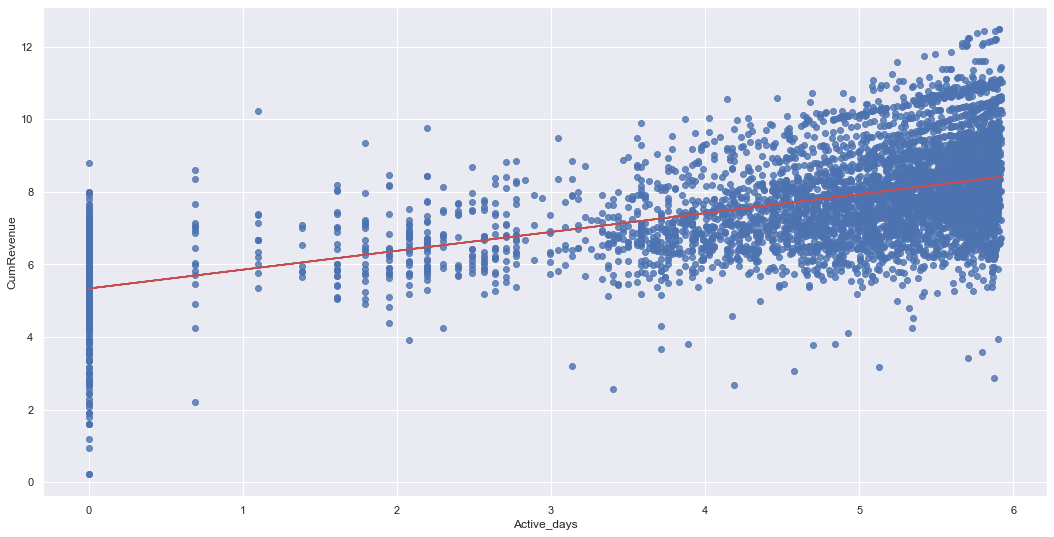

In [16]:
x_train_test = x_train.copy()
y_train_test = y_train.copy()

x_train_test['Active_days'] = x_train_test['Active_days'].apply(lambda x: np.log(x))
y_train_test['CumRevenue'] = y_train_test['CumRevenue'].apply(lambda x: np.log(x))

linr_test = LinearRegression()
linr_test.fit(x_train_test, y_train_test)
y_pred_test = linr_test.predict(x_train_test)


fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Active_days')
ax1.set_ylabel('CumRevenue')
ax1.scatter(x_train_test, y_train_test, alpha = 0.8)
ax1.plot(x_train_test, y_pred_test, 'r')

print('R-Square:',metrics.r2_score(y_train_test, y_pred_test))
print('MSE: ',metrics.mean_squared_error(y_train_test, y_pred_test))

Model has bad values of metrics, it is unfit for predictions. But it a lot better than previous models. 